## Reconstruct_PSI_bullet
## Data acquired at PSI, 28 Sept 2009
## Neutron tomography with D=20 mm pinhole, beamline length L = 6864 mm
## Exposure time: 140 seconds. Pixel size = 55 micron.
## Neutron detector developed by Dr. Anton Tremsin, UC Berkeley Space Science Center, "High-resolution neutron microtomography with noiseless neutron counting detector", Nucl. Instr. Meth. A, 652, (2011) 400-403.

In [11]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import os
from os import listdir
from os.path import isfile, join
import numpy  
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import string
from numpy.linalg import inv  #matrix calc
import math #log
import scipy
import scipy.ndimage
import scipy.signal #median filter for zero bad pixels
from astropy.io import fits #fits file read and writeTo
np.set_printoptions(suppress=True) #no scientific notations
import re #sort fits files
from IPython.display import clear_output #clear output
from pylab import *
from matplotlib import colors

## <span style="color:blue">Step 1: Initialize Functions</span>

funcCalculateAbsorption[closed_,open_,raw_]
   
   This function is basically the Beer-Lambert Law to calculate the optical absorption of an object based on the photons/neutrons entering the object compared to the photons exciting the sample.  Photons are often detected with devices that have a "dark" signal, even when the beam shutter is closed.  So, the equation for absorption is:   
   
   abs = Subscript[log, e][ (open beam data - closed beam data) / ( sample data -  closed beam  data ) ] 
Air (not an absorber) should have A = 0.  A lot of objects will have A = 0.5 to 1.5.  If the object is really thick, the theoretical value of A might be 3 or larger, but the detector will yield a useless result. If no photons/neutrons get to the detector, the denominator is zero.

funcReplacePixelsLessThanOrEqualZero[data_]
    
   The common detector is a CCD (also used in many cameras and similar to the CMOS camera in an iPhone).  In a high radiation environment, even if shielded from the main photons/neutrons beam, the CCD is damaged.  Often, a bad pixel leads to impossible absorption values.  So, replace the bad pixel with the median value (radius=1) of its neighbors.  A note about Mathematica;  The "Position" command has strangely awkward syntax, but executes nicely.  

In [8]:
def readFile(path, string):   #search string "white" and "raw"
    allFiles = [f for f in listdir(path) if isfile(join(path,f))]  
    for n in range(0, len(allFiles)):
        allFiles[n] = join(path,allFiles[n])
    allFiles.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]) 
    #use "regular expression" to sort filenames
    listfile = [];
    for seq in range (0, len(allFiles)):
        if string in allFiles[seq]:
            listfile.append(allFiles[seq])
    print ('There are '+ str(len(listfile))+ ' '+ string + ' files')        
    return(listfile)

In [392]:
def funcReplacePixelsLessThanOrEqualZeros(data):
    listCoordinates = np.transpose(np.where(data <= 0))
    #if (len(listCoordinates == 0)):
    #    return(data)
    dataFiltered = scipy.ndimage.filters.median_filter(data, 3)
    dataOutput = data
    for i in range(len(listCoordinates)):
        [r, c] = listCoordinates[i]
        dataOutput[r, c] = dataFiltered[r, c]
    return(dataOutput)

In [393]:
def funcReplacePixelsComplex(data):
    listCoordinates = np.transpose(np.where(data == complex))
    if (len(listCoordinates == 0)):
        return(data)
    #dataFiltered = scipy.signal.medfilt(data, 1)
    dataFiltered = scipy.ndimage.filters.median_filter(data, 3)
    dataOutput = data
    for i in range(len(listCoordinates)):
        [r, c] = listCoordinates[i]
        dataOutput[r, c] = dataFiltered[r, c]
    return(dataOutput)

In [394]:
def funcCalculateAbsorption(closed, Open, raw):
    numerator = Open - closed
    denominator = raw - closed
    numerator = funcReplacePixelsLessThanOrEqualZeros(numerator)
    denominator = funcReplacePixelsLessThanOrEqualZeros(denominator)
    dataAbsorption = np.log(numerator / denominator)
    dataAbsorption = funcReplacePixelsComplex(dataAbsorption)
    return(dataAbsorption)

## <span style="color:blue">Step 2: Read filenames. Check images and repair if necessary.</span>

This tutorial program will read the raw images in TEXT format.

makes a directory to store absorption data files in the FITS format.

### <span style="color:purple">Step 2a: Paths and Directories</span>

In [399]:
pathRoot = '/Users/jumaoyuan/Dropbox/VisTrails_1/workflow_mathematica_bullet'
pathRaw = os.path.join(pathRoot, 'TXT_raw_images')
pathAbsorption = os.path.join(pathRoot, 'FITS_abs_Py')
pathSinograms = os.path.join(pathRoot, 'FITS_sinograms')
pathFigures = os.path.join(pathRoot, 'PNG_figures')
try:
    os.stat(pathAbsorption)
except:
    os.mkdir(pathAbsorption)       
try:
    os.stat(pathFigures)
except:
    os.mkdir(pathFigures)       

### <span style="color:purple">Step 2b: Open Beam images (TEXT format); pixelSizeMM</span>

There are 1 Open files
256 256


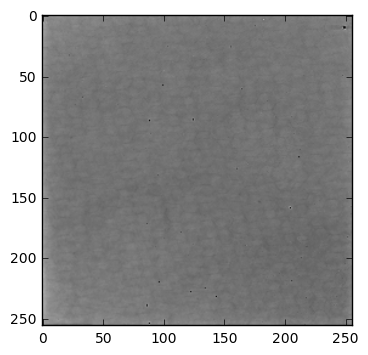

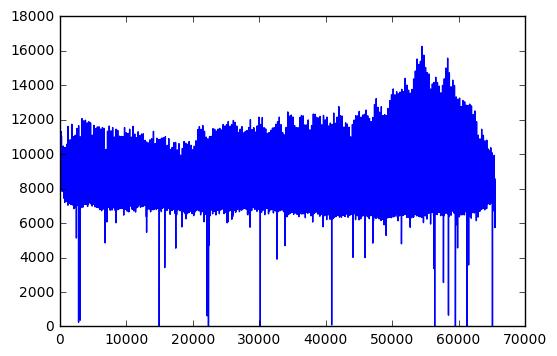

In [41]:
filename = readFile(pathRaw, "Open")
dataOpen = np.loadtxt(filename[0]) #read text image file
[rows, columns] = dataOpen.shape
print (rows, columns)
plt.imshow(dataOpen, cmap = 'gray')
plt.show()
plt.plot(dataOpen.flatten())
plt.show()

In [42]:
pixelSizeMM = 0.055

### <span style="color:purple">Step 2c: Closed Beam image (TEXT format)</span>

There are 1 Closed files


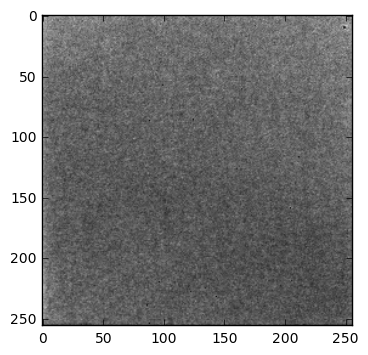

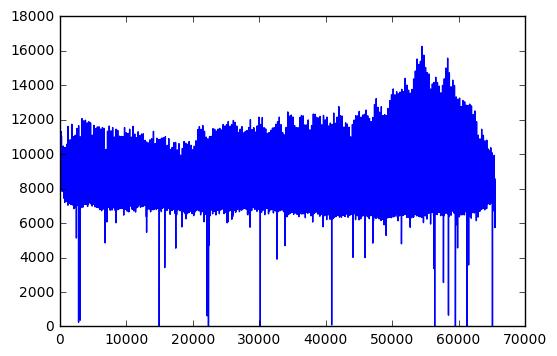

In [46]:
filename = readFile(pathRaw, 'Closed')
dataClosed = np.loadtxt(filename[0])
plt.imshow(dataClosed, cmap = 'gray')
plt.show()
plt.plot(dataOpen.flatten())
plt.show()

### <span style="color:purple">Step 2d: Find Raw images, sequence numbers, angles</span>

In [78]:
listFilenames = readFile(pathRaw, 'PSI_')
listFilenames[0:4]
numRaw = len(listFilenames)
numRaw

There are 202 PSI_ files


202

In [160]:
print (listFilenames[4].split('_'))
print ()
print (np.int(listFilenames[4].split('_')[7]))
print ()
print (listFilenames[4].split('_')[8].split('.')[0].split('p'))
firstAngle = listFilenames[4].split('_')[8].split('.')[0].split('p')[0]
secondAngle = np.str(np.int(listFilenames[4].split('_')[8].split('.')[0].split('p')[1]))
np.float(".".join([firstAngle, secondAngle]))

listSequenceNumbers = []
listAngles = []
for i in range(numRaw):
    firstAngle = listFilenames[i].split('_')[8].split('.')[0].split('p')[0]
    secondAngle = np.str(np.int(listFilenames[i].split('_')[8].split('.')[0].split('p')[1]))
    listAngles.append(np.float(".".join([firstAngle, secondAngle])))
    listSequenceNumbers.append(np.int(listFilenames[i].split('_')[7]))

['/Users/jumaoyuan/Dropbox/VisTrails', '1/workflow', 'mathematica', 'bullet/TXT', 'raw', 'images/PSI', 'bullet', '0005', '0003p0600.txt']

5

['0003', '0600']


[0.0, 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9.0, 9.9, 10.7, 11.6, 12.5, 13.4, 14.3, 15.2, 16.1, 17.0, 17.9, 18.8, 19.7, 20.6, 21.5, 22.4, 23.3, 24.2, 25.1, 26.0, 26.9, 27.8, 28.7, 29.6, 30.4, 31.3, 32.2, 33.1, 34.0, 34.9, 35.8, 36.7, 37.6, 38.5, 39.4, 40.3, 41.2, 42.1, 43.0, 43.9, 44.8, 45.7, 46.6, 47.5, 48.4, 49.3, 50.1, 51.0, 51.9, 52.8, 53.7, 54.6, 55.5, 56.4, 57.3, 58.2, 59.1, 60.0, 60.9, 61.8, 62.7, 63.6, 64.5, 65.4, 66.3, 67.2, 68.1, 69.0, 69.9, 70.7, 71.6, 72.5, 73.4, 74.3, 75.2, 76.1, 77.0, 77.9, 78.8, 79.7, 80.6, 81.5, 82.4, 83.3, 84.2, 85.1, 86.0, 86.9, 87.8, 88.7, 89.6, 90.4, 91.3, 92.2, 93.1, 94.0, 94.9, 95.8, 96.7, 97.6, 98.5, 99.4, 100.3, 101.2, 102.1, 103.0, 103.9, 104.8, 105.7, 106.6, 107.5, 108.4, 109.3, 110.1, 111.0, 111.9, 112.8, 113.7, 114.6, 115.5, 116.4, 117.3, 118.2, 119.1, 120.0, 120.9, 121.8, 122.7, 123.6, 124.5, 125.4, 126.3, 127.2, 128.1, 129.0, 129.9, 130.7, 131.6, 132.5, 133.4, 134.3, 135.2, 136.1, 137.0, 137.9, 138.8, 139.7, 140.6, 141.5, 142.4, 143

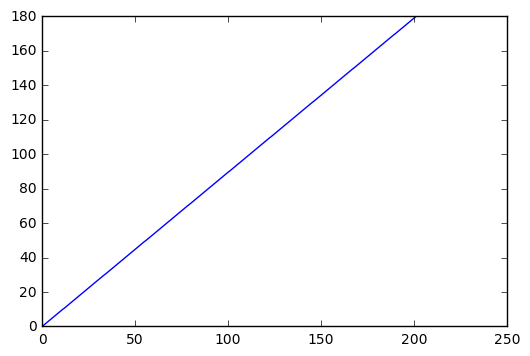

In [161]:
print (listAngles)
plt.plot(listAngles)
plt.show()

### <span style="color:purple">Step 2e: Import all images and inspect</span>

In [137]:
dataRawStack = np.zeros((numRaw, rows, columns))
for i in range(numRaw):
    dataRawStack[i,:,:] = np.loadtxt(listFilenames[i])

In [138]:
print (dataRawStack.shape)

(202, 256, 256)


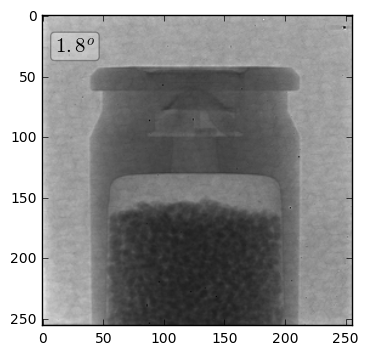

1.8

In [139]:
index = 2
plt.imshow(dataRawStack[index,:,:], cmap = 'gray')
annotate('$1.8^o$',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
listAngles[index]

### <span style="color:purple">Step 2f: Details of images #22 and #46</span>

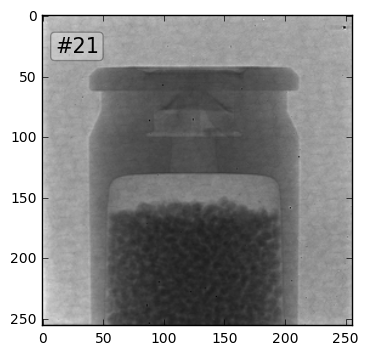

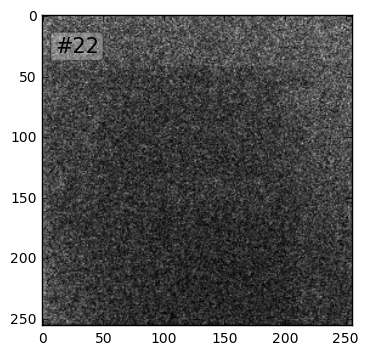

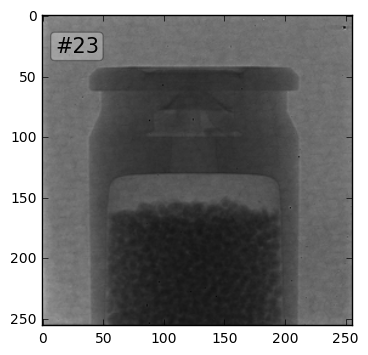

In [140]:
index = 21
plt.imshow(dataRawStack[index-1, :, :], cmap = 'gray')
annotate('#21',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index, :, :], cmap = 'gray')
annotate('#22',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index+1, :, :], cmap = 'gray')
annotate('#23',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()

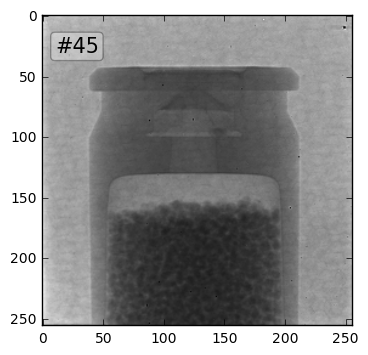

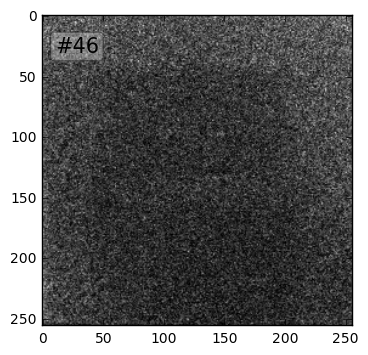

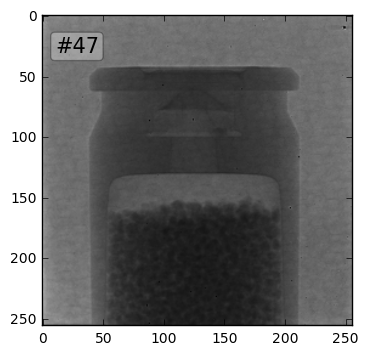

In [141]:
index = 45
plt.imshow(dataRawStack[index-1, :, :], cmap = 'gray')
annotate('#45',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index, :, :], cmap = 'gray')
annotate('#46',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index+1, :, :], cmap = 'gray')
annotate('#47',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()

### <span style="color:purple">Step 2g: Correct images #22 and #46 with mean of images acquired before and after</span>

In [142]:
index = 21
dataRawStack[index, :, :] = (dataRawStack[index-1, :, :] + dataRawStack[index+1, :, :])/2

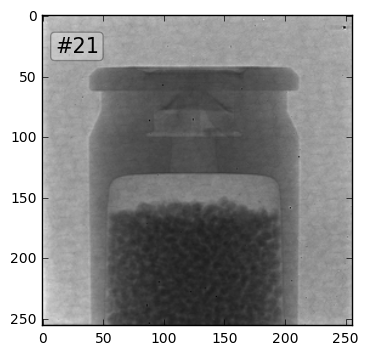

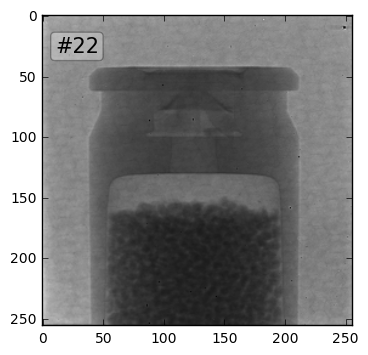

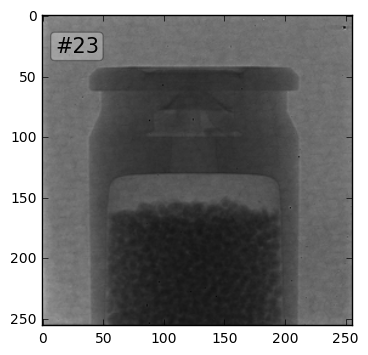

In [143]:
plt.imshow(dataRawStack[index-1, :, :], cmap = 'gray')
annotate('#21',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index, :, :], cmap = 'gray')
annotate('#22',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index+1, :, :], cmap = 'gray')
annotate('#23',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()

In [144]:
index = 45
dataRawStack[index, :, :] = (dataRawStack[index-1, :, :] + dataRawStack[index+1, :, :])/2

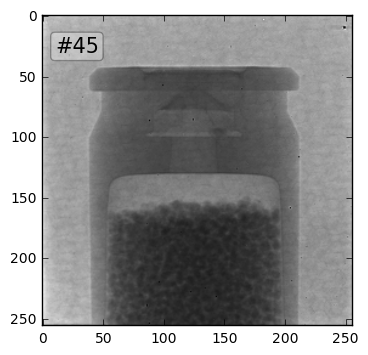

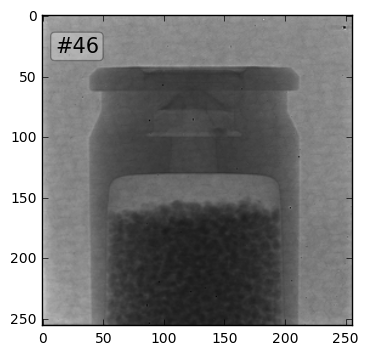

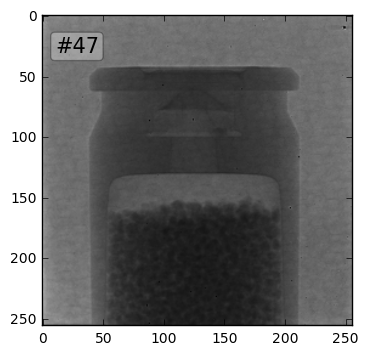

In [145]:
plt.imshow(dataRawStack[index-1, :, :], cmap = 'gray')
annotate('#45',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index, :, :], cmap = 'gray')
annotate('#46',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
plt.imshow(dataRawStack[index+1, :, :], cmap = 'gray')
annotate('#47',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()

## <span style="color:blue">Step 3: Calculate absorption projections as a function of rotation angle</span>

### <span style="color:purple">Step 3a: Calculate absorption projections</span>

In [401]:
for indexImage in range(numRaw):
    dataRaw = dataRawStack[indexImage, :, :]
    dataAbsorption = funcCalculateAbsorption(dataClosed, dataOpen, dataRaw)
    sequenceNumber = listSequenceNumbers[indexImage]
    angle = listAngles[indexImage]
    print(indexImage, sequenceNumber, angle)
    newFilename = 'absorption_' + np.str(sequenceNumber).zfill(4) + '_' + np.str(angle) + '.fits'
    absFilename = os.path.join(pathAbsorption, newFilename)
    try: #remove file if exits
        os.remove(absFilename)
    except OSError:
        pass
    absFits = fits.HDUList([fits.PrimaryHDU(dataAbsorption)])
    absFits.writeto(absFilename)
    absFits.close()
    clear_output()

### <span style="color:purple">Step 3b: Plot a representative absorption</span>

There are 202 abs files
Filename: /Users/jumaoyuan/Dropbox/VisTrails_1/workflow_mathematica_bullet/FITS_abs_Py/absorption_0003_1.8.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (256, 256)   float64   


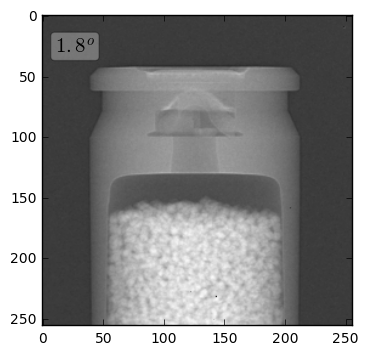

1.8

In [412]:
index = 2
listFilenames = readFile(pathAbsorption, 'abs')
angle = listAngles[index]
oneImage = fits.open(listFilenames[index])
oneImage.info()
#oneImage.close()
oneImageArray = oneImage[0].data
oneImageArray.shape
plt.imshow(oneImageArray, cmap = 'gray')
annotate('$1.8^o$',xy=(0,0), xytext=(10,30), fontsize=15, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.3))
plt.show()
angle